# Búsqueda del mejor modelo de regresión para los datos de España

In [1]:
#Se importan los módulos y librerias que se van a utilizar para realizar el análisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Math, Latex

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from scipy import stats

In [2]:
#Definir el path donde se encuentra el dataset con los datos de confirmados
path1="Dataset\\COVID-19-master\\csse_covid_19_data\\csse_covid_19_time_series\\time_series_covid19_confirmed_global.csv"

In [3]:
data_confirmed=pd.read_csv(path1)
Data_Confirmed_Spain=data_confirmed[data_confirmed["Country/Region"]=="Spain"]

In [4]:
Data_Confirmed_Spain.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/16/20,8/17/20,8/18/20,8/19/20,8/20/20,8/21/20,8/22/20,8/23/20,8/24/20,8/25/20
226,NaN,Spain,40.463667,-3.74922,0,0,0,0,0,0,...,342813,359082,364196,370867,377906,386054,386054,386054,405436,412553


In [5]:
#Lista con valores de fecha (evadiendolas 4 primeras filas)
date_value_list=data_confirmed.columns.values.tolist()
date_value=date_value_list[4:]
#Lista de confirmados
confirmed_value=Data_Confirmed_Spain.iloc[0,4:].tolist()
(len(date_value),len(confirmed_value))

(217, 217)

In [6]:
#Se trabaja con el número de días, no con las fechas
n_dias=range(1,len(date_value)+1)
n_dias_list=list(n_dias)
len(n_dias_list)

217

In [7]:
#Preparación del DataFrame
Spain_Data=pd.DataFrame({
    "Días":n_dias_list,
    "Total Confirmados":confirmed_value,
})

In [8]:
#Del DataFrame muestra las 10 primeras
Spain_Data.head(10)

,Días,Total Confirmados
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [9]:
#Del DataFrame muestra las 10 últimas
Spain_Data.tail(10)

,Días,Total Confirmados
207,208,342813
208,209,359082
209,210,364196
210,211,370867
211,212,377906
212,213,386054
213,214,386054
214,215,386054
215,216,405436
216,217,412553


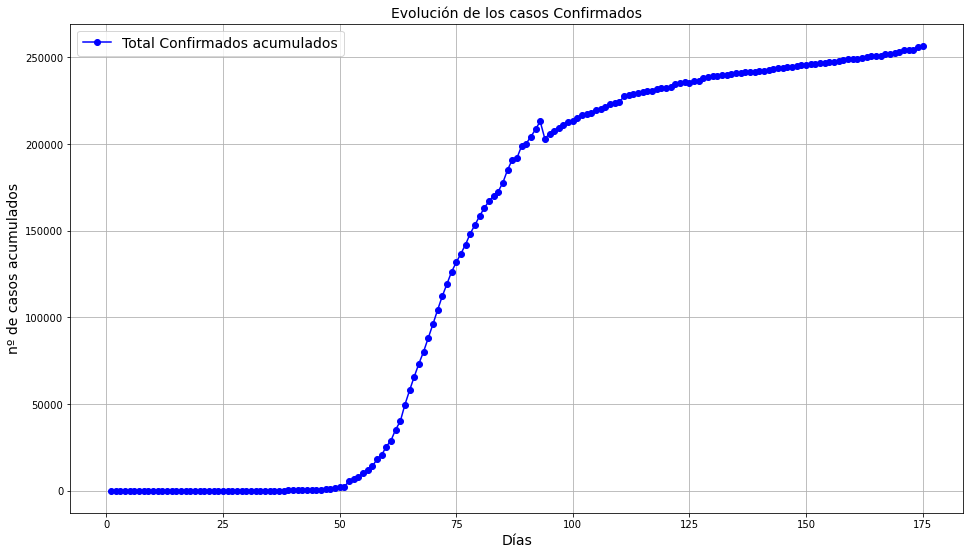

In [10]:
#Se pretende trabajar con los datos hasta finalizar la primera ola, la cual duró aproximadamente 175 días
x=Spain_Data["Días"][0:175]
y=Spain_Data["Total Confirmados"][0:175]

fig, ax=plt.subplots(figsize=(16,9))
ax.grid(True)
ax.plot(x,y,'-ob', label="Total Confirmados acumulados")
ax.set_xlabel("Días").set_fontsize(14)
ax.set_ylabel("nº de casos acumulados").set_fontsize(14)
ax.set_title("Evolución de los casos Confirmados").set_fontsize(14)
ax.legend(prop={"size":14})

## Busqueda de la regresión que más se ajuste a la curva (Regresión univariable)
1.Se comenzará con las regresiones simples, donde la única variable independiente será el nº de días
* Se analizará la regresión lineal simple
* La regresión polinómica simple
* La regresión exponencial simple


## Regresión Lineal

* Primero se comprueba la correlación lineal existente entre variables obteniendo el coeficiente y el P-valor
* Los resultados muestran que tiene mucho sentido aplicar una regresión lineal simple 

In [11]:
correl_test=pearsonr(x,y)
print("Coeficiente de correlación lineal de pearson ", correl_test[0])
print("P-valor:", correl_test[1])

Coeficiente de correlación lineal de pearson  0.9384955346838867
P-valor: 8.234790186888743e-82


In [12]:
#División de los datos en datos para entrenar el modelo y datos para testearlo
x=Spain_Data[["Días"]][0:175]
y=Spain_Data["Total Confirmados"][0:175]
x_train,x_test, y_train,y_test=train_test_split(
    x.values.reshape(-1,1),
    y.values.reshape(-1,1),
    train_size=0.8,
    random_state=2021,
    shuffle=True)

In [13]:
#Creación del modelo
modelo_lineal=LinearRegression()
x=x_train.reshape(-1,1)
y=y_train
modelo_lineal.fit(x,y)

LinearRegression()

In [14]:
#Parámetros descriptivos del modelo
print("Intercet: ", modelo_lineal.intercept_)
print("Coeficiente Días: ", modelo_lineal.coef_)
print("Coeficiente de determinación R^2", modelo_lineal.score(x,y))
R_ml=modelo_lineal.score(x,y)

Intercet:  [-41414.52354461]
Coeficiente Días:  [[2026.59698972]]
Coeficiente de determinación R^2 0.8775188235528371


In [15]:
#Evaluación de la capacidad predictiva del modelo con los datos test
x=x_test
predicciones_modelo_lineal=modelo_lineal.predict(x)

In [16]:
#Se procede a calcular el error cuadrático medio
rmse=mean_squared_error(
    y_true=y_test,
    y_pred=predicciones_modelo_lineal,
    squared=False
)

print("El error cuadrático medio del modelo lineal es: ", rmse)

El error cuadrático medio del modelo lineal es:  35418.70965822019


In [17]:
#Para verificar el resultado de rmse, se procede a su cálculo mediante las ecuaciones
#De esta forma, para otros modelos se precederá utilizando solo las ecuaciones, ya que los módulos de trabajo
#no disponen de procedimientos sólidos para otro tipo de regresiones que no sean la lineal
#Valor, Nuevos factores estadisticos
x=Spain_Data[["Días"]][0:175]
y=Spain_Data["Total Confirmados"][0:175]
x=x.values.reshape(-1,1)
y=y.values.reshape(-1,1)
SSD_ml=np.sum((y-modelo_lineal.predict(x))**2)
RSE_ml=np.sqrt(SSD_ml/(len(y)-2))
y_mean=np.mean(y)
error_ml=(RSE_ml/y_mean)*100
print("Desviación estandar: ", SSD_ml)
print("Error estandar residual: ", RSE_ml)
print("Valor medio: ", y_mean)
print("Porcentaje del error respecto al valor medio: ", error_ml)

Desviación estandar:  242197424990.40387
Error estandar residual:  37416.37496540074
Valor medio:  136848.57142857142
Porcentaje del error respecto al valor medio:  27.34144359331536


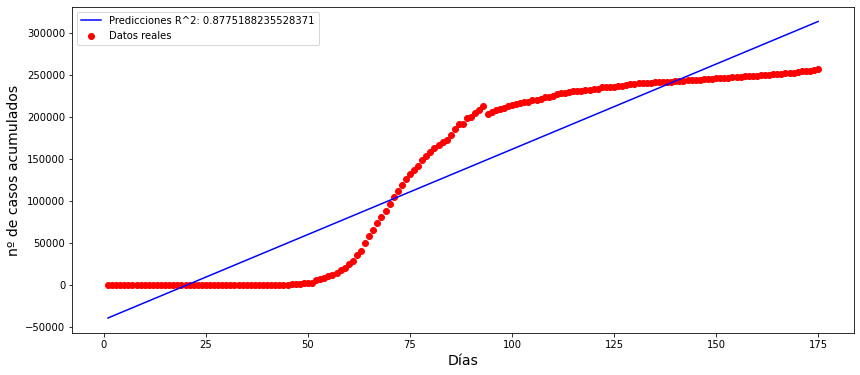

In [18]:
x=Spain_Data[["Días"]][0:175]
y=Spain_Data["Total Confirmados"][0:175]
fig, ax=plt.subplots(figsize=(14,6))
ax.set_xlabel("Días").set_fontsize(14)
ax.set_ylabel("nº de casos acumulados").set_fontsize(14)
ax.scatter(x,y,marker='o',color='red',label="Datos reales")
ax.plot(x,modelo_lineal.predict(x),linestyle='-',color="blue", label="Predicciones R^2: {0}".format(R_ml))
ax.legend();

## Regresión polinómica

Regresión de grado 2
R^2 es: 0.8948781820437909
[-75407.08832106]
[[   0.         3153.06326974   -6.37599354]]
Regresión de grado 3
R^2 es: 0.9590874695050448
[6266.1067692]
[[ 0.00000000e+00 -2.13258837e+03  6.75047713e+01 -2.78584106e-01]]
Regresión de grado 4
R^2 es: 0.9763081182077086
[56560.3295385]
[[ 0.00000000e+00 -7.45814960e+03  2.01193483e+02 -1.45455070e+00
   3.34320461e-03]]
Regresión de grado 5
R^2 es: 0.9835308780349425
[16399.94166408]
[[ 0.00000000e+00 -1.37775468e+03 -2.97986835e+01  1.96368379e+00
  -1.82300239e-02  4.87157324e-05]]
Regresión de grado 6
R^2 es: 0.9932682778511297
[-38969.01661041]
[[ 0.00000000e+00  9.86753240e+03 -6.33115936e+02  1.53172578e+01
  -1.58539762e-01  7.45029830e-04 -1.31373003e-06]]
Regresión de grado 7
R^2 es: 0.9933744890628393
[-30754.13074483]
[[ 0.00000000e+00  7.94820167e+03 -4.99571055e+02  1.12727816e+01
  -9.67049476e-02  2.45320413e-04  7.22615373e-07 -3.29370670e-09]]
Regresión de grado 8
R^2 es: 0.9936896602134379
[11297.3

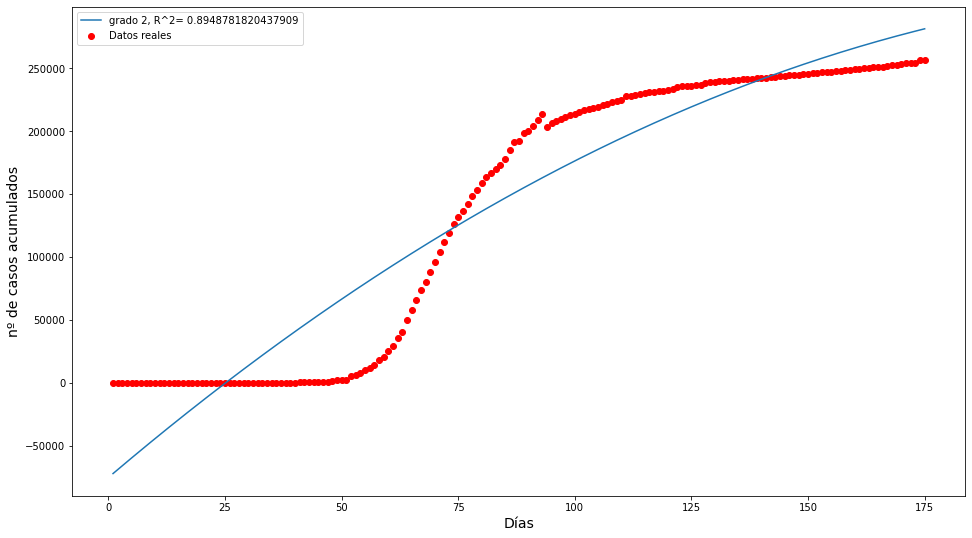

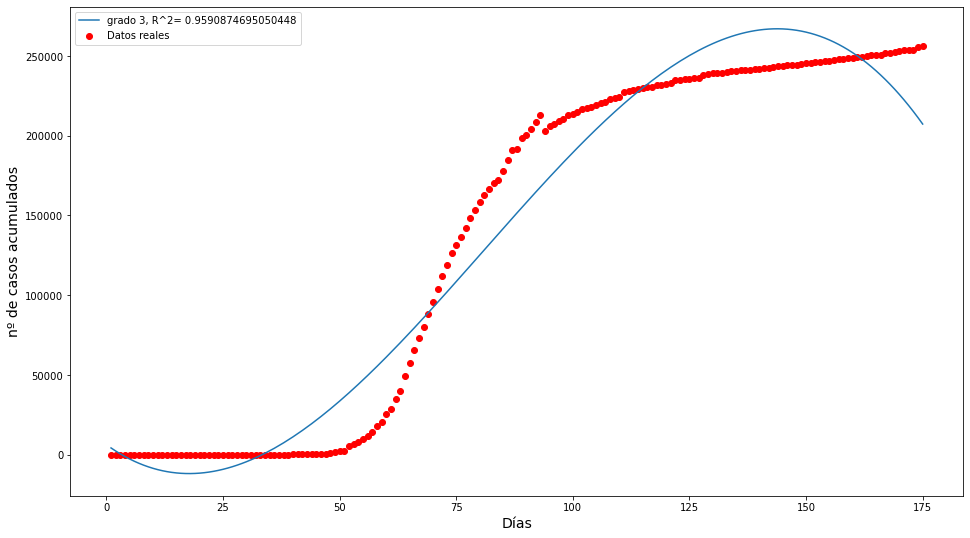

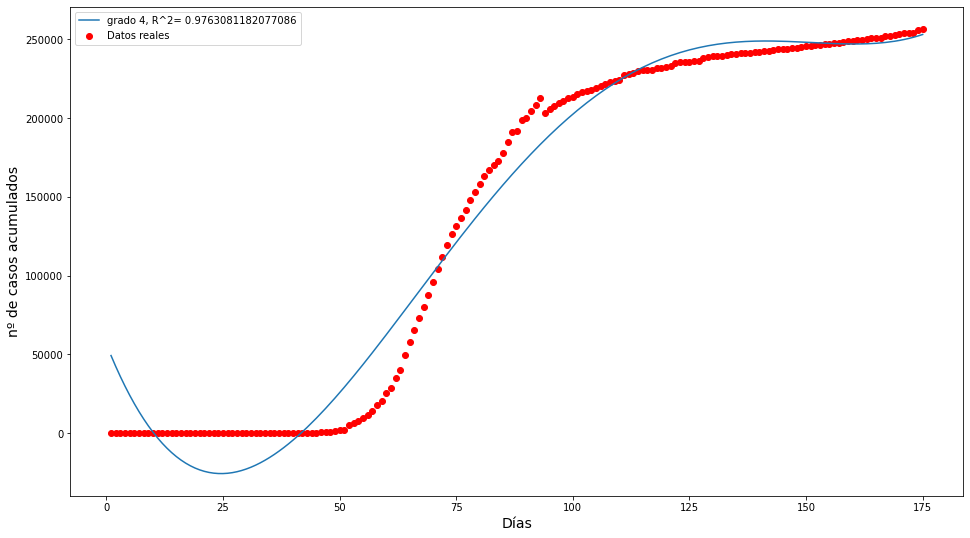

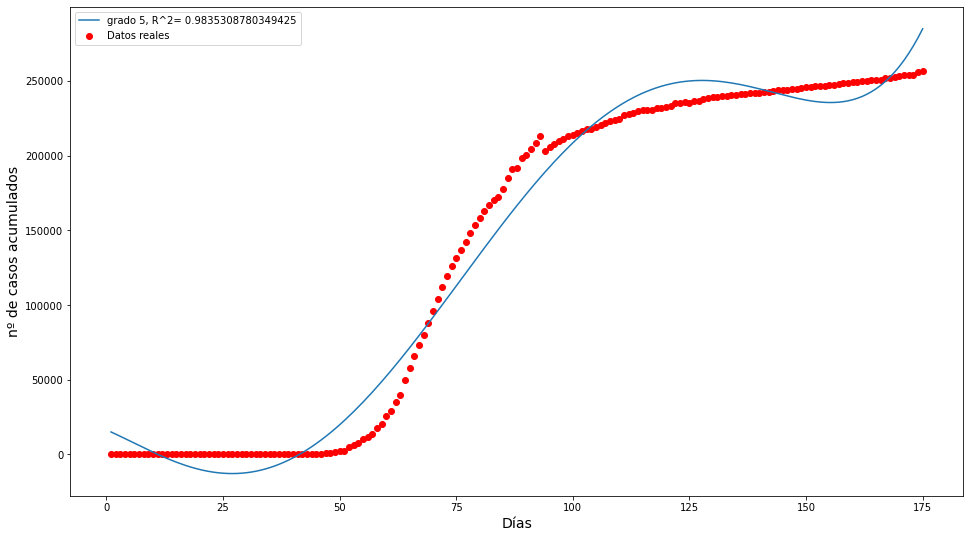

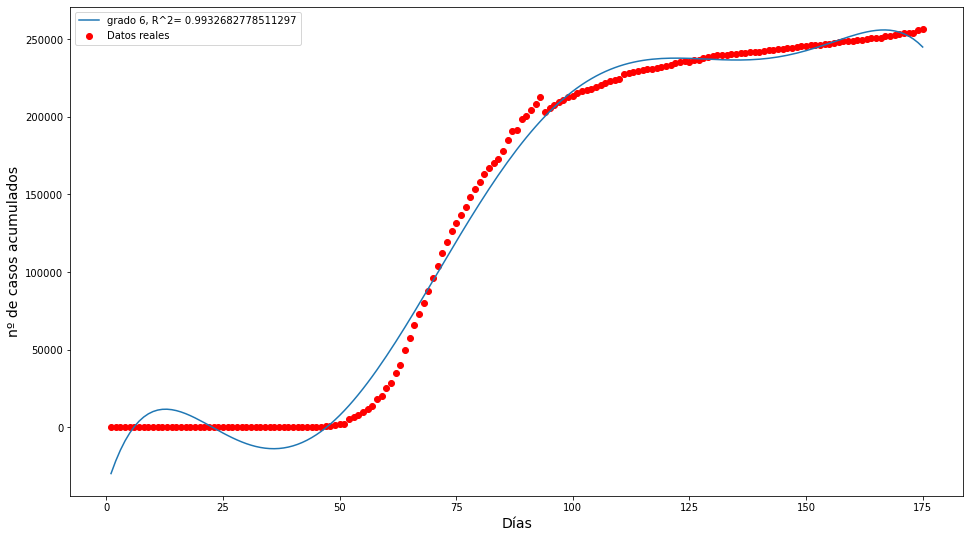

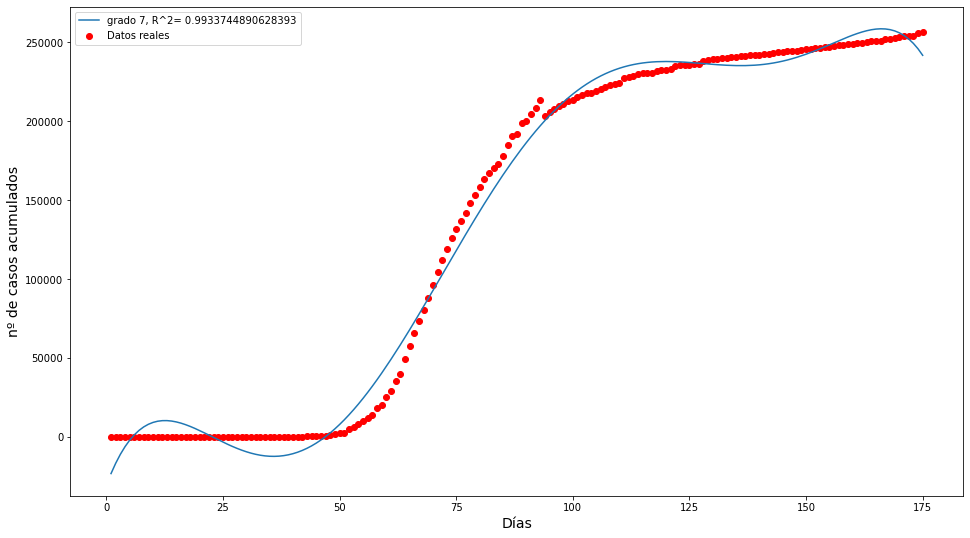

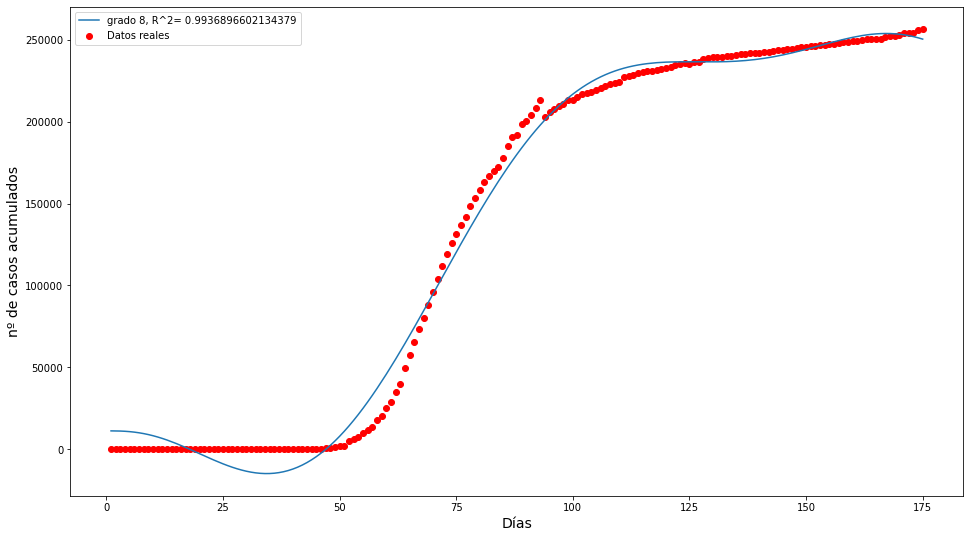

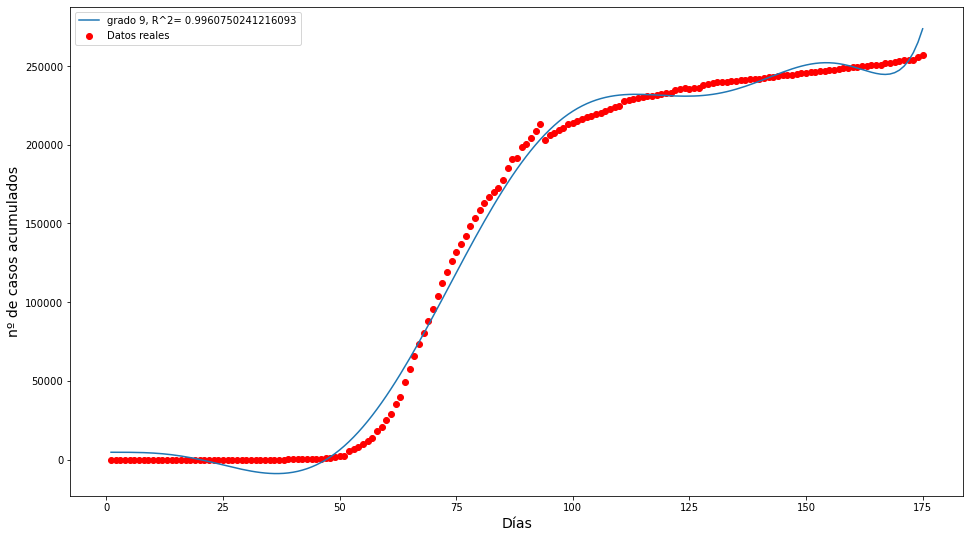

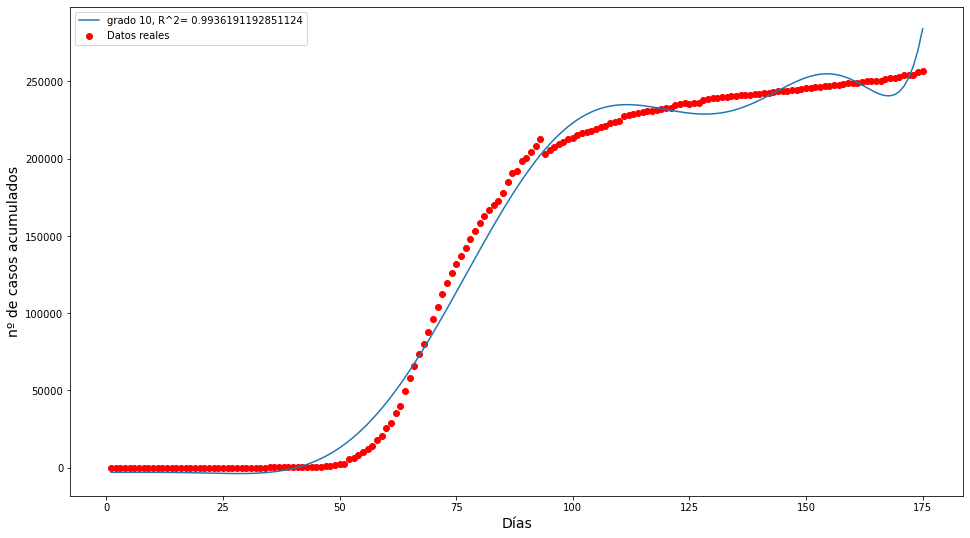

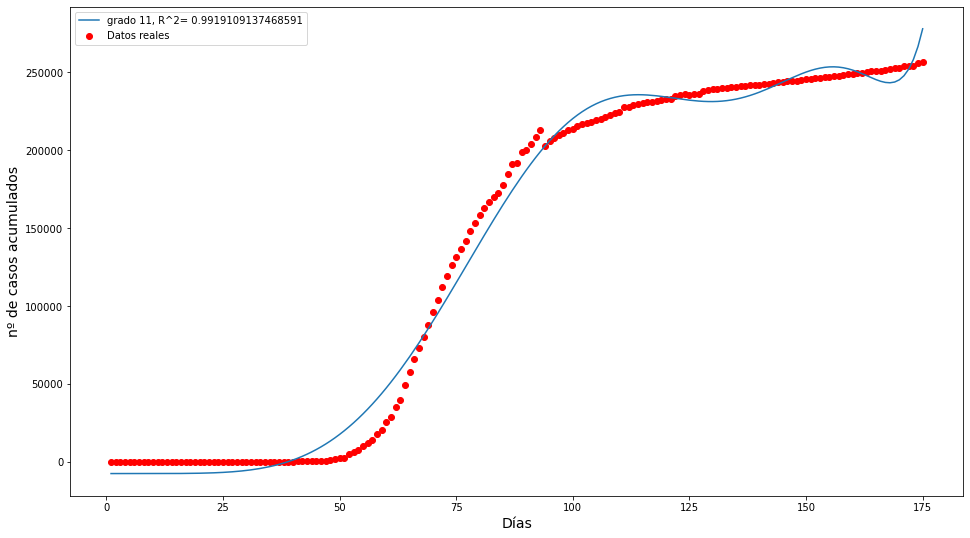

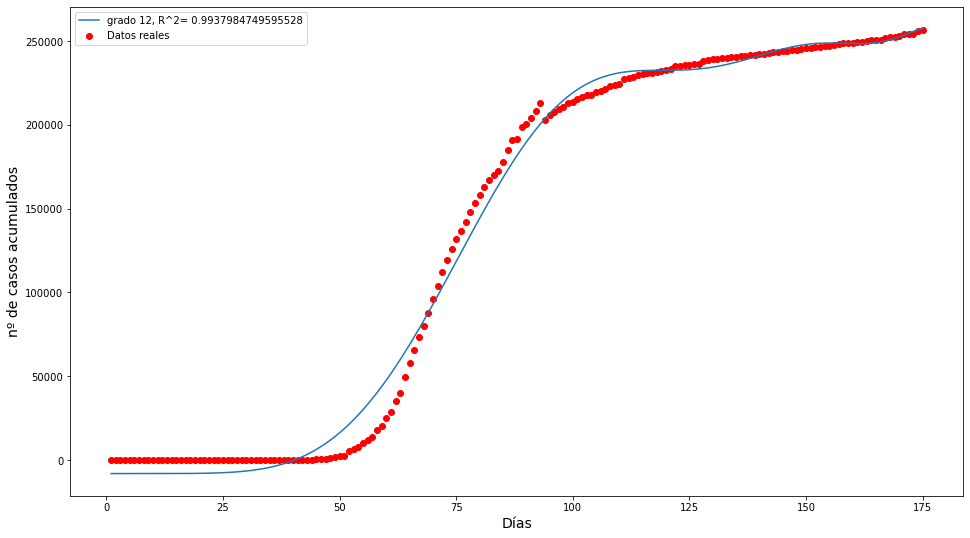

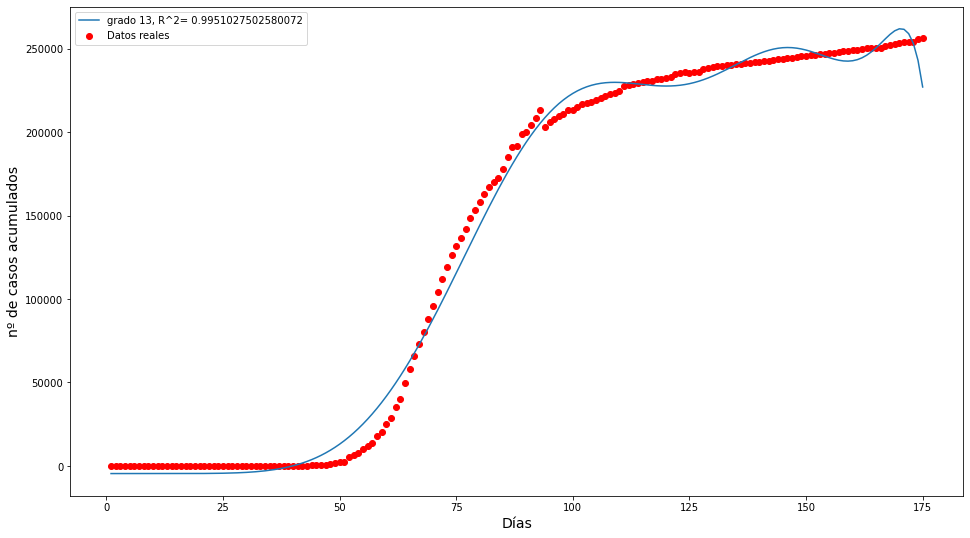

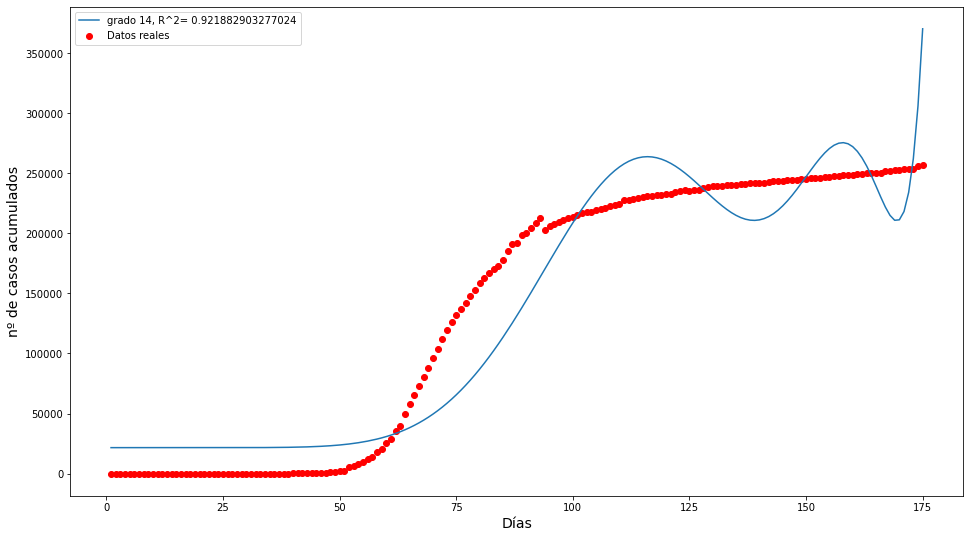

In [19]:
#División de los datos en conjunto de prueba y conjunto de entrenamiento
y=Spain_Data["Total Confirmados"][0:175].values.reshape(-1,1)
for i in range(2,15):
    poly_regre=PolynomialFeatures(degree=i)
    x=Spain_Data["Días"][0:175].values.reshape(-1,1)
    x_data=poly_regre.fit_transform(x)
    modelo_poli=LinearRegression()
    x_train,x_test,y_train,y_test=train_test_split(
        x_data,
        y,
        test_size=0.2,
        random_state=2021,
        shuffle=True)
    #Entrenamiento del modelo
    modelo_poli.fit(x_train,y_train)
    y_predict=modelo_poli.predict(x_data)
    x=Spain_Data["Días"][0:175].values.reshape(-1,1)
    y=Spain_Data["Total Confirmados"][0:175].values.reshape(-1,1)
    
    fig, ax=plt.subplots(figsize=(16,9))
    ax.set_xlabel("Días").set_fontsize(14)
    ax.set_ylabel("nº de casos acumulados").set_fontsize(14)
    ax.scatter(x,y,marker='o',color='red',label="Datos reales")
    ax.plot(x,y_predict, label="grado {0}, R^2= {1}".format(i,modelo_poli.score(x_train,y_train)))
    ax.legend();
    print("Regresión de grado "+str(i))
    print("R^2 es: "+ str(modelo_poli.score(x_train,y_train)))
    print(modelo_poli.intercept_)
    print(modelo_poli.coef_)

* A mayor grado del polinomio, mayor valor de R^2. mayor problema de sobreajuste.
* En las representaciones se observa que el polinomio de grado 12 es el que mejor se ajusta a los datos reales
* No obstante. El grado es demaciado alto. para trabajar con grados de polinomio menores, se observa que el de grado 4 es el que mejor se comporta respecto a los datos reales

In [20]:
y=Spain_Data["Total Confirmados"][0:175].values.reshape(-1,1)
poly_regre=PolynomialFeatures(degree=4)
x=Spain_Data["Días"][0:175].values.reshape(-1,1)
x_data=poly_regre.fit_transform(x)
modelo_poli=LinearRegression()
x_train,x_test,y_train,y_test=train_test_split(
    x_data,
    y,
    test_size=0.2,
    random_state=2021,
    shuffle=True)
#Entrenamiento del modelo
modelo_poli.fit(x_train,y_train)
y_predict=modelo_poli.predict(x_data)
    
print("Regresión de grado 4")
print("R^2 es: ", modelo_poli.score(x_train,y_train))
print("Intercep: ", modelo_poli.intercept_)
print("Coeficientes:", modelo_poli.coef_)
R_mp=modelo_poli.score(x_train,y_train)

Regresión de grado 4
R^2 es:  0.9763081182077086
Intercep:  [56560.3295385]
Coeficientes: [[ 0.00000000e+00 -7.45814960e+03  2.01193483e+02 -1.45455070e+00
   3.34320461e-03]]


In [21]:
#Valor, Nuevos factores estadisticos
y=Spain_Data["Total Confirmados"][0:175].values.reshape(-1,1)
SSD_mp=np.sum((y-y_predict)**2)
RSE_mp=np.sqrt(SSD_mp/(len(y)-2))
y_mean=np.mean(y)
error_mp=(RSE_mp/y_mean)*100
print("Desviación estandar: ", SSD_mp)
print("Error estandar residual: ", RSE_mp)
print("Valor medio: ", y_mean)
print("Porcentaje del error respecto al valor medio: ", error_mp)

Desviación estandar:  50540718926.44641
Error estandar residual:  17092.187805190366
Valor medio:  136848.57142857142
Porcentaje del error respecto al valor medio:  12.489854754612248


## Modelo de crecimiento Logístico simple

* La regresión exponencial simple, se ha descartado debido al comportamiento de la función exponencial. La cual la limita para elaborar un modelo predictivo que tenga en cuenta la totalidad de los datos.
* No obstante, los modelos de crecimiento logístico incorporan el comportamiento de la función exponencial, además permiten trabajar con la totalidad de los datos (necesario para el estudio que se desea realizar)

In [22]:
display(Math(r"N=\frac{y0}{1+exp{\frac{-(t-t0)}{T}}}"))


<IPython.core.display.Math object>

In [23]:
def func(t,y0,t0,T):
    return y0/(1+np.exp(-(t-t0)/T))

[2.40521646e+05 7.51314380e+01 8.82531272e+00]


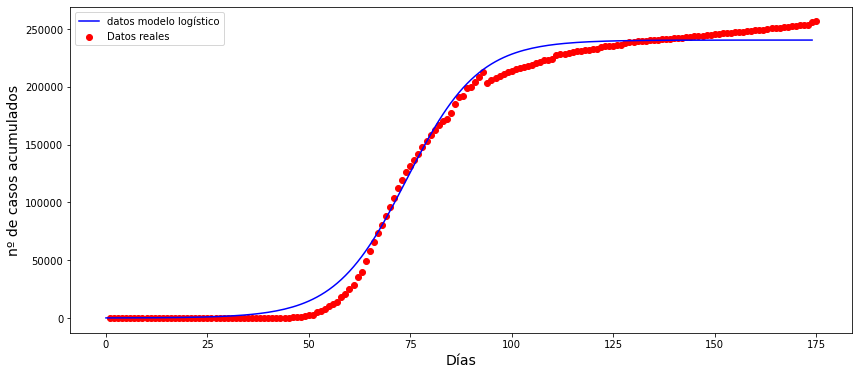

In [24]:
xData=np.array(Spain_Data["Días"][0:175])
yData=np.array(Spain_Data["Total Confirmados"][0:175])
#Ajuste de la ecuación a la evolución de los datos pasandole xData=t e yData=N
#Curve_fit, busca el valor del resto de parámetros, minimizando el error
popt,pcov=curve_fit(func,xData,yData)
print(popt)
xFit=np.arange(0,175,1)
fig, ax=plt.subplots(figsize=(14,6))
ax.scatter(xData,yData,marker='o',color='red',label='Datos reales')
ax.set_xlabel("Días").set_fontsize(14)
ax.set_ylabel("nº de casos acumulados").set_fontsize(14)
ax.plot(xFit, func(xData,*popt),'b',label='datos modelo logístico')
ax.legend(loc='upper left');


In [25]:
#Cálculo de R^2
y_opt=func(xData,*popt)
R_mcl=r2_score(y_opt,yData)
R_mcl

0.9947703056662655

In [26]:
#Valor, Nuevos factores estadisticos
xData=np.array(Spain_Data["Días"][0:175])
yData=np.array(Spain_Data["Total Confirmados"][0:175])
SSD_mcl=np.sum((yData-y_opt)**2)
RSE_mcl=np.sqrt(SSD_mcl/(len(yData)-2))
y_mean=np.mean(yData)
error_mcl=(RSE_mcl/y_mean)*100
print("Desviación estandar: ", SSD_mcl)
print("Error estandar residual: ", RSE_mcl)
print("Valor medio: ", y_mean)
print("Porcentaje del error respecto al valor medio: ", error_mcl)


Desviación estandar:  10280545819.055107
Error estandar residual:  7708.769054872445
Valor medio:  136848.57142857142
Porcentaje del error respecto al valor medio:  5.633065054607504


### Conclusiones
1. En la regresión simple, se observa que el modelo de regresión que más se ajusta a los datos reales es el modelo de crecimiento logístico. 
2. El modelo polinomial, tiene una buena R2,No obstante, un elevado grado del polinomio, además de sufrir problemas de sobreajuste. Por esta razón, es un modelo no aplicable para el objetivo final del proyecto.
3. A pesar de disponer de un valor de R^2 menor que la obtenida en los otros modelos, con la regresión lineal se obtiene un valor alto de R^2 (0.8775188235528371), lo que significa que es capaz de interpretar el 87,7% de los datos.
4. Se ha decidido trabajar para la regresión multivairiable, que solo se realizará el caso de regresión lineal multivariable. Los motivos son fundamentalmente debido a que una regresión múltiple por lo general aumenta el valor de R^2 y las metodologías, módulos, bibliotecas disponibles para este modelo son mucho más amplias que las disponibles para el resto de modelos analizados. 

In [27]:
 Dconclusiones=pd.DataFrame({
     "R^2":[R_ml,R_mp,R_mcl],
     "Desviación estandar":[SSD_ml,SSD_mp,SSD_mcl],
     "Error estandar residual":[RSE_ml,RSE_mp,RSE_mcl],
     "% error valor medio:":[error_ml,error_mp,error_mcl]
 }, index=["Modelo Lineal","Modelo Polinomial", "Modelo de Crecimiento Logístico"])

In [28]:
Dconclusiones

,R^2,Desviación estandar,Error estandar residual,% error valor medio:
Modelo Lineal,0.877519,2.421974e+11,37416.374965,27.341444
Modelo Polinomial,0.976308,5.054072e+10,17092.187805,12.489855
Modelo de Crecimiento Logístico,0.994770,1.028055e+10,7708.769055,5.633065


## Regresión Lineal multivariable 
### Análisis de variables cuantitativas y categóricas
1. La variable cuantitativa con la que se tratará será el número de días
2. Las variables cualitativas serán las decisiones relavantes tomadas durante la primera ola
3. Dichas variables categóricas se transformarán en cuantitativas. En este caso se analizarán dos situaciones
4. Una vez transformadas dichas variables, se procederá a aplicar la regrsión lineal multivariable

In [29]:
#Determinación de las variables categóricas
Dic_Desiciones_España=pd.DataFrame({
    "Fecha_Inicio":["14-03-2020","29-03-2020","21-04-2020","23-05-2020","26-05-2020","21-06-2020","07-07-2020"],
    "Fecha_Fin":["N/A","09-04-2020","N/A","23-06-2020","21-06-2020","N/A","N/A"],
    "Siglas_Desición":["EA","CTNE","SMC","CTF","IDes","NN","EV_SpC"],
    "Significado":["Estado Alarma","Confinamiento Trabajadores No Esenciales",
    "Salida de menores de 14","Cierre Total Frontera","Inicio Desescalada",
    "Nueva Normalidad","Entrada de viajeros sin posibilidad de cuarentena"]
})


In [30]:
Dic_Desiciones_España

,Fecha_Inicio,Fecha_Fin,Siglas_Desición,Significado
0,14-03-2020,N/A,EA,Estado Alarma
1,29-03-2020,09-04-2020,CTNE,Confinamiento Trabajadores No Esenciales
2,21-04-2020,N/A,SMC,Salida de menores de 14
3,23-05-2020,23-06-2020,CTF,Cierre Total Frontera
4,26-05-2020,21-06-2020,IDes,Inicio Desescalada
5,21-06-2020,N/A,NN,Nueva Normalidad
6,07-07-2020,N/A,EV_SpC,Entrada de viajeros sin posibilidad de cuarentena


In [31]:
from datetime import datetime
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%d-%m-%Y")
    d2 = datetime.strptime(d2, "%d-%m-%Y")
    return abs((d2 - d1).days)

In [32]:
days_between('22-01-2020', '14-03-2020')

52

In [33]:
Spain_Data=Spain_Data[0:175]

### Transformación de las variables categóricas a variables tipo entero
1. En este caso, Se toma una decisión, se estima que cuantos más días pasen con la decisión tomada está tendrá mayor efecto por lo tanto, cuando la decisión este tomada, el valor de la variable que representa dicha decisión pasa de 0 a 1, e irá incrementando al pasar los días en 1 unidad, cuando se anule dicha decisión, esta tomará valor 0 de nuevo. 


In [34]:
def PreparacionData(dic_siglas_desiciones=Dic_Desiciones_España['Siglas_Desición']):
    #Convertir la columna en una lista, para poder recorrerla con un bucle for
    dic_siglas_desiciones=dic_siglas_desiciones.tolist()
    #Variable contador, para recorrer las filas
    j=0
    #Variable para guardar los dataframe generados, partiendo del dataframe Spain_Data
    datos_nuevos=Spain_Data
    
    #Se recorre la lista dic_siglas_desiciones, para ir analizando decisión a decisión
    for i in dic_siglas_desiciones:
        #generación de una lista vacia para almacenar los valores correspondientes a cada lista
        l=[]
        
        #Se pretende calcular la diferencia de días existente entre el inicio de la existencia de registros de datos
        #a el día en que se toma la decisión
        d1=Dic_Desiciones_España['Fecha_Inicio'][j]
        dini='22-01-2020'
        total_dias_ini=days_between(dini,d1)
        
         #Se pretende calcular la diferencia de días existente entre el inicio de la existencia de registros de datos
        #a el día en que finaliza la decisión tomada (N/A) significa que aún sigue en vigor la decisión
        d2=Dic_Desiciones_España['Fecha_Fin'][j]
        if d2=='N/A':
            d2='01-08-2020'   
        total_dias_fin=days_between(dini,d2)

        
        #Los días en el que la decisión este en vigor tendrán un valor diferente a 0. El resto de días tendrán un valor igual a 0
        
        k=1
        for w in range(1,176):
            #Añadele valor 0 si la decisión no está tomada
            if w<total_dias_ini:
                l.append(0)
            #Cuando la decisión está tomada, ponle valor x
            elif w>total_dias_ini and w<total_dias_fin:
                l.append(k)
                k=k+1
            #Cuando la decisión ha sido revocada, ponle valor 0
            else:
                l.append(0)
        
        #Crea un dataframe de una columna correspondiente a los valores de la decisión que se está analizando
        df = pd. DataFrame({i:l,
                    })
        #Concatena dicho dataFrame con el de datos_nuevos
        frames=[datos_nuevos,df]
        datos_nuevos=pd.concat(frames,axis=1)
        j=j+1
        
    return datos_nuevos
        

In [35]:
#Se utiliza la función que transforma las variables categóricas en enteros
#A continuación se muestran los resultados
datos_nuevos=PreparacionData()
datos_nuevos

,Días,Total Confirmados,EA,CTNE,SMC,CTF,IDes,NN,EV_SpC
0,1,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
170,171,253908,119,0,81,0,0,20,4
171,172,253908,120,0,82,0,0,21,5
172,173,253908,121,0,83,0,0,22,6
173,174,255953,122,0,84,0,0,23,7


1. Primero se procede a analizar la relación existente entre las variables independientes (con el coeficiente de correlación de pearson). Es deseable, la no existencia de colinealidad entre dichas variables
2. R2, al ser un modelo lineal múltiple, los valores de R2 no son comparables con los obtenidos en el modelo simple.Por lo general, el valor de R^2 será superior en la regresión múltiple
* El estudio del medelo F-test. Garantiza conocer la importancia de cada predictor en los resultados. Si F es significativo, el modelo es útil
* En los modelos múltiples, los predictores deben de ser independientes. Si existe colinealidad, no se puede identificar el efecto de cada predictor en el modelo. Existe colinealidad-->coefColinialidad=1

In [36]:
#Matriz de correlación entre las variables
corr_mat=datos_nuevos.corr(method='pearson')
corr_mat

,Días,Total Confirmados,EA,CTNE,SMC,CTF,IDes,NN,EV_SpC
Días,1.000000,0.938496,0.972550,-0.060086,0.888171,0.417003,0.374345,0.537771,0.325290
Total Confirmados,0.938496,1.000000,0.919354,-0.025813,0.754801,0.381958,0.344694,0.366609,0.212456
EA,0.972550,0.919354,1.000000,-0.113837,0.951572,0.441115,0.395595,0.597918,0.364077
CTNE,-0.060086,-0.025813,-0.113837,1.000000,-0.164882,-0.084062,-0.075929,-0.074246,-0.042081
SMC,0.888171,0.754801,0.951572,-0.164882,1.000000,0.443953,0.396748,0.703823,0.436605
CTF,0.417003,0.381958,0.441115,-0.084062,0.443953,1.000000,0.886212,-0.127772,-0.075251
IDes,0.374345,0.344694,0.395595,-0.075929,0.396748,0.886212,1.000000,-0.119923,-0.067970
NN,0.537771,0.366609,0.597918,-0.074246,0.703823,-0.127772,-0.119923,1.000000,0.773556
EV_SpC,0.325290,0.212456,0.364077,-0.042081,0.436605,-0.075251,-0.067970,0.773556,1.000000


#### Relación entre variables

In [37]:
# Función para obtener la matriz de correlación en formato tidy, ordenada de mayor a menor

def matriz_correlacion(corr_mat):
    #Apliando las variables 
    corr_mat = corr_mat.stack().reset_index()
    #Cambio del nombre de las columnas
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    #Se añade otra columna. con el valor absoluto de la columna r
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    #Rodenar la matriz de mayor a menor en función de abs_r
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

In [38]:
matriz_correlacion(corr_mat)

,variable_1,variable_2,r,abs_r
18,EA,Días,0.972550,0.972550
2,Días,EA,0.972550,0.972550
38,SMC,EA,0.951572,0.951572
22,EA,SMC,0.951572,0.951572
1,Días,Total Confirmados,0.938496,0.938496
...,...,...,...,...
3,Días,CTNE,-0.060086,0.060086
35,CTNE,EV_SpC,-0.042081,0.042081
75,EV_SpC,CTNE,-0.042081,0.042081
12,Total Confirmados,CTNE,-0.025813,0.025813


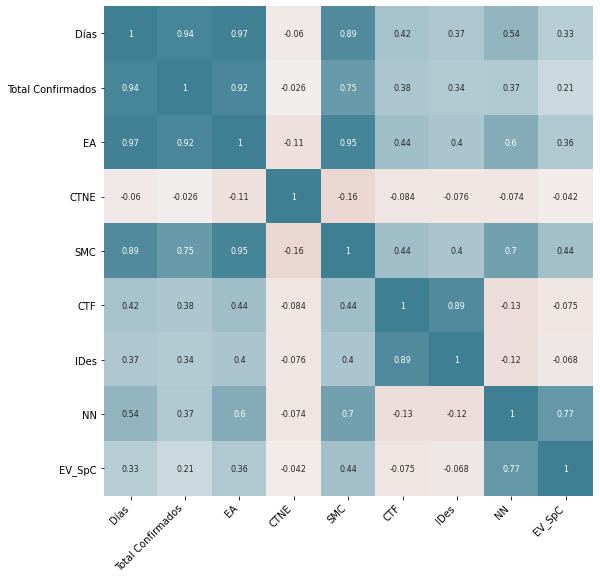

In [39]:
# Heatmap matriz de correlaciones para una mejor visualización
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

sns.heatmap(
    corr_mat,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

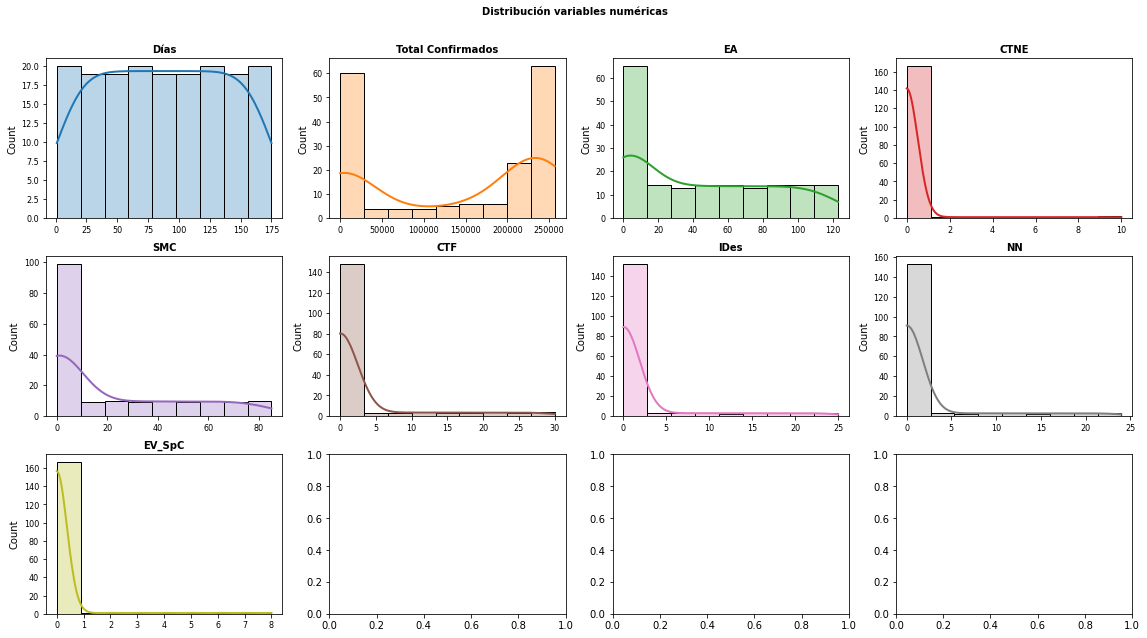

In [40]:
# Se procede a analizar la distribución de cada una de las variables
#Variable x es el valor de las variables, variable y es el conteo de número de valores existentes
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 9))
axes = axes.flat
columnas_numeric = datos_nuevos.columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = datos_nuevos,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")


    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

In [41]:
# Se procede a elaborar el modelo

X = datos_nuevos[['Días','EA','CTNE','SMC','CTF','IDes','NN','EV_SpC']]
y = datos_nuevos['Total Confirmados']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [42]:
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.257e+04
Date:                Sat, 22 May 2021   Prob (F-statistic):          5.06e-185
Time:                        19:09:23   Log-Likelihood:                -1354.8
No. Observations:                 140   AIC:                             2728.
Df Residuals:                     131   BIC:                             2754.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1820.2263   1145.653      1.589      0.1

* Lo primero que se observa, es que el modelo sufre claramente de overfitting. 
* Uno de los principales problemas se debe a la existencia de elevada colinealidad entre las variables independientes
* Por lo tanto se descarta el cambio de variable categórica a númerica aplicada
* Se procede transformando las variables categóricas en variables booleanas.

### Transformación de las variables categóricas a variables booleanas
* Las variables valdrán 0 cuando la medida no esté en vigor, 1 cuando la medida esta en vigor.


In [43]:
def PreparacionData(dic_siglas_desiciones=Dic_Desiciones_España['Siglas_Desición']):
    #Convertir la columna en una lista, para poder recorrerla con un bucle for
    dic_siglas_desiciones=dic_siglas_desiciones.tolist()
    #Variable contador, para recorrer las filas
    j=0
    #Variable para guardar los dataframe generados, partiendo del dataframe Spain_Data
    datos_nuevos=Spain_Data
    
    #Se recorre la lista dic_siglas_desiciones, para ir analizando decisión a decisión
    for i in dic_siglas_desiciones:
        #generación de una lista vacia para almacenar los valores correspondientes a cada lista
        l=[]
        
        #Se pretende calcular la diferencia de días existente entre el inicio de la existencia de registros de datos
        #a el día en que se toma la decisión
        d1=Dic_Desiciones_España['Fecha_Inicio'][j]
        dini='22-01-2020'
        total_dias_ini=days_between(dini,d1)
        
         #Se pretende calcular la diferencia de días existente entre el inicio de la existencia de registros de datos
        #a el día en que finaliza la decisión tomada (N/A) significa que aún sigue en vigor la decisión
        d2=Dic_Desiciones_España['Fecha_Fin'][j]
        if d2=='N/A':
            d2='01-08-2020'   
        total_dias_fin=days_between(dini,d2)

        
        #Los días en el que la decisión este en vigor tendrán un valor diferente a 0. El resto de días tendrán valor 1
        
        for w in range(1,176):
            #Añadele valor 0 si la decisión no está tomada
            if w<total_dias_ini:
                l.append(0)
            #Cuando la decisión está tomada, ponle valor x
            elif w>total_dias_ini and w<total_dias_fin:
                l.append(1)
            #Cuando la decisión ha sido revocada, ponle valor 0
            else:
                l.append(0)
        
        #Crea un dataframe de una columna correspondiente a los valores de la decisión que se está analizando
        df = pd. DataFrame({i:l,
                    })
        #Concatena dicho dataFrame con el de datos_nuevos
        frames=[datos_nuevos,df]
        datos_nuevos=pd.concat(frames,axis=1)
        j=j+1
        
    return datos_nuevos


In [44]:
datos_nuevos_bool=PreparacionData()
datos_nuevos_bool

,Días,Total Confirmados,EA,CTNE,SMC,CTF,IDes,NN,EV_SpC
0,1,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
170,171,253908,1,0,1,0,0,1,1
171,172,253908,1,0,1,0,0,1,1
172,173,253908,1,0,1,0,0,1,1
173,174,255953,1,0,1,0,0,1,1


In [45]:
#Matriz de correlación entre las variables
corr_mat_bool=datos_nuevos_bool.corr(method='pearson')
corr_mat_bool

,Días,Total Confirmados,EA,CTNE,SMC,CTF,IDes,NN,EV_SpC
Días,1.000000,0.938496,0.791560,-0.075535,0.865686,0.445699,0.404068,0.595832,0.361770
Total Confirmados,0.938496,1.000000,0.824638,-0.053201,0.894682,0.440570,0.396488,0.420917,0.238139
EA,0.791560,0.824638,1.000000,0.160069,0.631884,0.295751,0.265444,0.259219,0.142310
CTNE,-0.075535,-0.053201,0.160069,1.000000,-0.239247,-0.111979,-0.100504,-0.098147,-0.053882
SMC,0.865686,0.894682,0.631884,-0.239247,1.000000,0.468046,0.420084,0.410231,0.225216
CTF,0.445699,0.440570,0.295751,-0.111979,0.468046,1.000000,0.897527,-0.137264,-0.099555
IDes,0.404068,0.396488,0.265444,-0.100504,0.420084,0.897527,1.000000,-0.162758,-0.089353
NN,0.595832,0.420917,0.259219,-0.098147,0.410231,-0.137264,-0.162758,1.000000,0.548997
EV_SpC,0.361770,0.238139,0.142310,-0.053882,0.225216,-0.099555,-0.089353,0.548997,1.000000


In [46]:
matriz_correlacion(corr_mat_bool)

,variable_1,variable_2,r,abs_r
1,Días,Total Confirmados,0.938496,0.938496
9,Total Confirmados,Días,0.938496,0.938496
59,IDes,CTF,0.897527,0.897527
51,CTF,IDes,0.897527,0.897527
13,Total Confirmados,SMC,0.894682,0.894682
...,...,...,...,...
27,CTNE,Días,-0.075535,0.075535
75,EV_SpC,CTNE,-0.053882,0.053882
35,CTNE,EV_SpC,-0.053882,0.053882
28,CTNE,Total Confirmados,-0.053201,0.053201


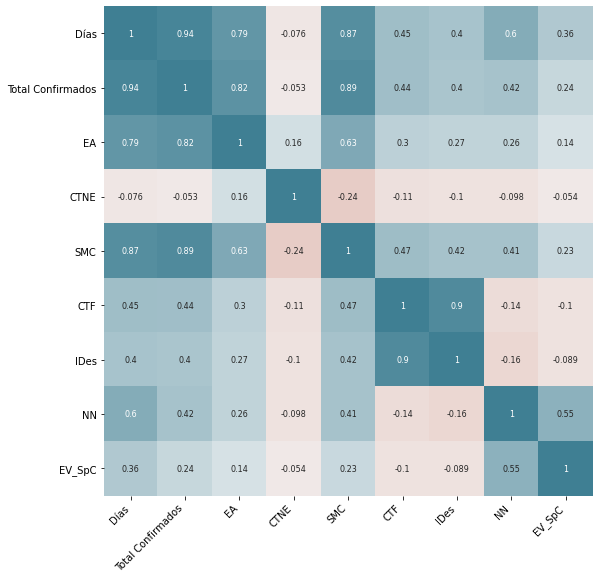

In [47]:
# Heatmap matriz de correlaciones para una mejor visualización
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 9))

sns.heatmap(
    corr_mat_bool,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

* Se observa la existencia de menor colinealidad general con esta forma de trabajo que con la anterior

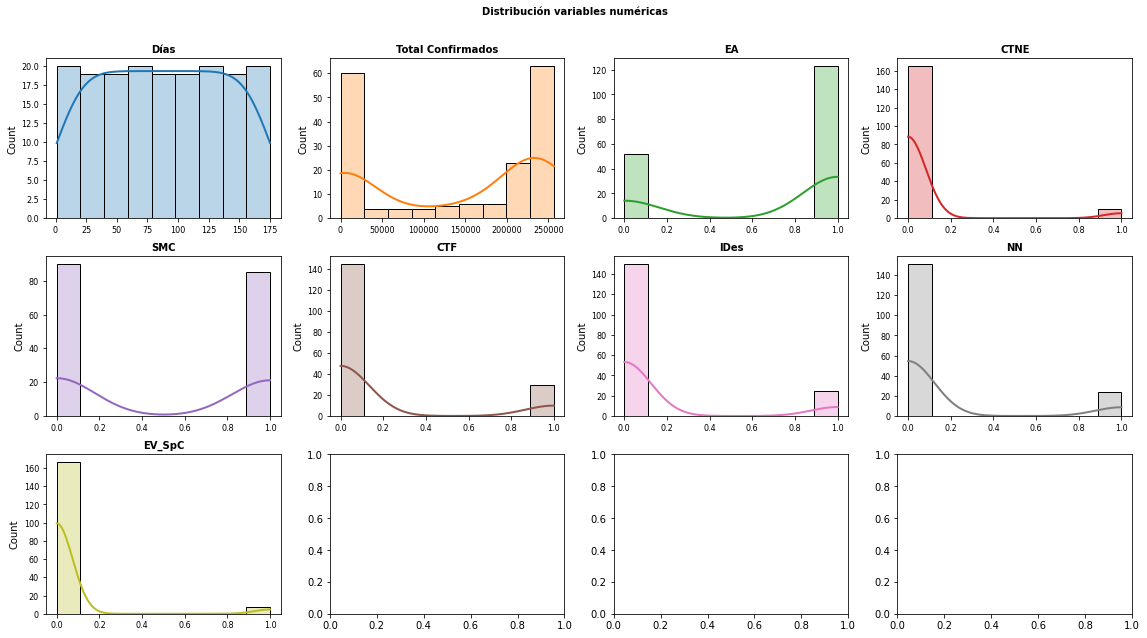

In [48]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 9))
axes = axes.flat
columnas_numeric = datos_nuevos_bool.columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = datos_nuevos_bool,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")


    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

In [49]:
X = datos_nuevos_bool[['Días','EA','CTNE','SMC','CTF','IDes','NN','EV_SpC']]
y = datos_nuevos_bool['Total Confirmados']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [50]:
X_train = sm.add_constant(X_train, prepend=True)
modelo = sm.OLS(endog=y_train, exog=X_train)
modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                     289.3
Date:                Sat, 22 May 2021   Prob (F-statistic):           2.39e-79
Time:                        19:09:47   Log-Likelihood:                -1615.0
No. Observations:                 140   AIC:                             3248.
Df Residuals:                     131   BIC:                             3274.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.308e+04   6339.165     -5.218      0.0

* Con los cambios realizados se ha conseguido reducir el overfitting.
* Se pueden utilizar diferentes procedimientos para asignar valores a las variables categóricas. El objetivo es reducir la colinialidad y obtener un valor de R^2 mayor al obtenido en la regresión simple (0.8775188235528371), este debe ser mayor o igual en la regresión múltiple, sin llegar al overfitting.
* Por lo tanto, se procederá a trabajar con las variables booleanas
* Analizando los P-valores, se concluye que el P-valor obtenido por el modelo es consistente. Para los p-valor de las variables. Se pueden descartar las siguientes decisiones ya que, su aportación no es significativa en el modelo, (CTNE, CTF)
* Se procede a entrenar el modelo de nuevo sin estas dos variables

In [51]:
X_train = X_train.drop(columns = ['CTNE','CTF'])
X_test  = X_test.drop(columns = ['CTNE','CTF'])
X_train = sm.add_constant(X_train, prepend=True)
modelo  = sm.OLS(endog=y_train, exog=X_train,)
modelo  = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     391.5
Date:                Sat, 22 May 2021   Prob (F-statistic):           6.32e-82
Time:                        19:09:51   Log-Likelihood:                -1615.0
No. Observations:                 140   AIC:                             3244.
Df Residuals:                     133   BIC:                             3265.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.288e+04   6245.388     -5.265      0.0

* Como se observa se obtiene un R^2 prácticamente igual, pero con las variables categóricas más significativas
* Las variables más significativas en este caso son Días=EA=SMC>NN>Ides>EV_SpC (orden de importancia de las decisiones, en función de como afectan a la evolución de los datos en el modelo establecido)
* Modelo:
    Total Confirmados=-3.288e+04+1280.1600*Dias+5.211e+04*EA+6.397e+04*SMC-1.87e+04*IDes-3.849e+04*NN-9977.5748*EV_SpC

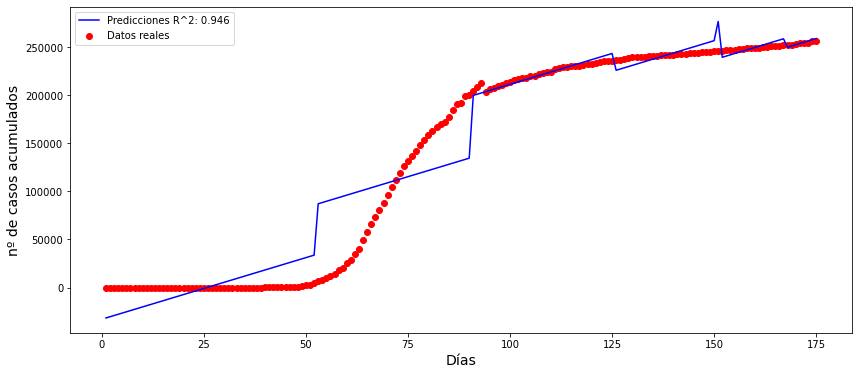

In [52]:
pred=-3.288e+04+1280.1600*datos_nuevos_bool['Días']+5.211e+04*datos_nuevos_bool['EA']+6.397e+04*datos_nuevos_bool['SMC']-1.87e+04*datos_nuevos_bool['IDes']-3.849e+04*datos_nuevos_bool['NN']-9977.5748*datos_nuevos_bool['EV_SpC']
x=Spain_Data[["Días"]][0:175]
y=Spain_Data["Total Confirmados"][0:175]
fig, ax=plt.subplots(figsize=(14,6))
ax.set_xlabel("Días").set_fontsize(14)
ax.set_ylabel("nº de casos acumulados").set_fontsize(14)
ax.scatter(x,y,marker='o',color='red',label="Datos reales")
ax.plot(x,pred,linestyle='-',color="blue", label="Predicciones R^2: {0}".format(0.946))
ax.legend();

In [53]:
SSD_mlm=np.sum((y-pred)**2)
RSE_mlm=np.sqrt(SSD_mlm/(len(y)-7))
y_mean=np.mean(y)
error_ml=(RSE_mlm/y_mean)*100
print("Desviación estandar: ", SSD_ml)
print("Error estandar residual: ", RSE_ml)
print("Valor medio: ", y_mean)
print("Porcentaje del error respecto al valor medio: ", error_ml)

Desviación estandar:  242197424990.40387
Error estandar residual:  37416.37496540074
Valor medio:  136848.57142857142
Porcentaje del error respecto al valor medio:  19.814017968836826
